In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi, _ = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax): 
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw(xs, zlist, edges): #edges追加
    ax = make_ax()
    draw_trajectory(xs, ax)
    draw_observations(xs, zlist, ax)
    draw_edges(edges, ax)
    plt.show()

In [3]:
def read_data():#データの読み込み
    hat_xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
    zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）

    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
                
        return hat_xs, zlist

In [4]:
class Edge: ###graphbasedslam3edge
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]): #sensor_noise_rate追加
        assert z1[0] == z2[0] #ランドマークのIDが違ったら処理を止める
            
        self.landmark_id = z1[0]
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.x1, self.x2 = xs[t1], xs[t2]    #各時刻の姿勢
        self.z1, self.z2 = z1[1], z2[1]     #各時刻のセンサ値
        
        ##精度行列の作成##
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        A = np.array([[-c1, self.z1[0]*s1, 0],
                                [-s1, -self.z1[0]*c1, 0],
                                [ 0, 1, -1]])
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        B = np.array([[c2, -self.z2[0]*s2, 0],
                                [s2, self.z2[0]*c2, 0],
                                [ 0, -1, 1]])
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        
        self.Sigma = A.dot(Q1).dot(A.T) + B.dot(Q2).dot(B.T)
        self.Omega = np.linalg.inv(self.Sigma)
        
    def __str__(self): #Omega追加
        return "landmark:{}, x1:{}, x2:{}, z1:{}, z2:{}, \nΣ:{}".format(self.landmark_id, self.x1, self.x2, self.z1, self.z2, self.Sigma) 

In [5]:
import itertools 
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録 

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [Edge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges

<IPython.core.display.Javascript object>


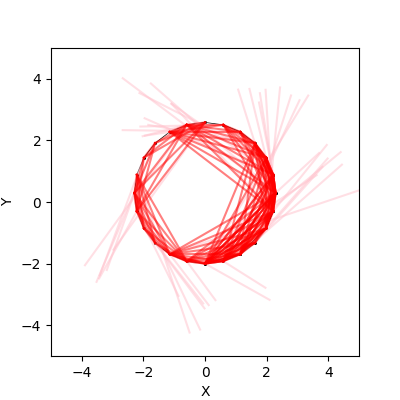

In [6]:
hat_xs, zlist = read_data() 
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)

In [7]:
for e in edges:
    print(e)

landmark:1, x1:[ 0. -2.  0.], x2:[ 0.59316956 -1.92190775  0.26179939], z1:[ 2.40294815 -0.51164741  2.70076561], z2:[ 1.61753547 -0.82434002  2.52359376], 
Σ:[[ 0.12805921 -0.06233755 -0.00509802]
 [-0.06233755  0.05737262 -0.00865876]
 [-0.00509802 -0.00865876  0.01      ]]
landmark:1, x1:[ 0. -2.  0.], x2:[-1.14591559 -1.69295284  5.75958653], z1:[ 2.40294815 -0.51164741  2.70076561], z2:[6.52907796 0.84856316 2.39211935], 
Σ:[[ 0.85072245  0.17840302  0.00227013]
 [ 0.17840302  0.21898427 -0.02070646]
 [ 0.00227013 -0.02070646  0.01      ]]
landmark:1, x1:[ 0. -2.  0.], x2:[-0.59316956 -1.92190775  6.02138592], z1:[ 2.40294815 -0.51164741  2.70076561], z2:[5.05805731 0.84697854 2.502927  ], 
Σ:[[ 0.45747706  0.15928538  0.00404323]
 [ 0.15928538  0.23553703 -0.01577922]
 [ 0.00404323 -0.01577922  0.01      ]]
landmark:1, x1:[ 0. -2.  0.], x2:[-4.44089210e-15 -2.00000000e+00  6.28318531e+00], z1:[ 2.40294815 -0.51164741  2.70076561], z2:[5.70208686 0.68777639 2.53894918], 
Σ:[[ 0.50